In [56]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.io.arff

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# data pre-processing
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [57]:
# carregando o dataset
data, meta = scipy.io.arff.loadarff(f'data/speeddating.arff')
df = pd.DataFrame(data)

# Convertendo byte-strings para strings
str_df = df.select_dtypes([object]).stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]

# ajeitar o tipo dos dados
nominal_cols = [col for col, dtype in zip(meta.names(), meta.types()) if dtype == 'nominal']
for col in nominal_cols:
    df[col] = df[col].astype('category')

## Outliers e inconsistências

In [58]:
numeric_columns = df.select_dtypes(include=['number'])
# dropando colunas nao muito interessantes ou que os dados se repetem, como pref_o_atributo e atributo_important
numeric_columns.drop(
    columns=[
        'wave', 'age_o', 'd_age', 'attractive_important',
        'sincere_important', 'intellicence_important', 'funny_important',
        'ambtition_important', 'shared_interests_important'
        ],
      inplace=True
    )

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_21304\105454958.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Column", y="Value", data=df_melted, palette='coolwarm', flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 6})


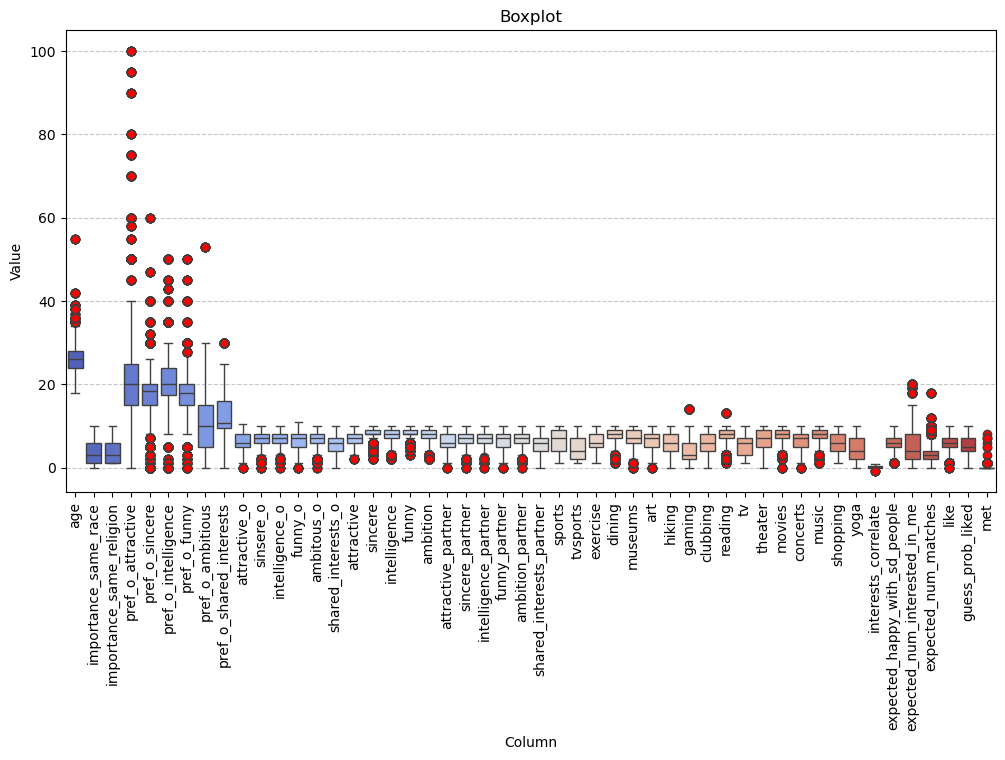

In [4]:
df_melted = numeric_columns.melt(var_name="Column", value_name="Value")

plt.figure(figsize=(12, 6))

# boxplot
sns.boxplot(x="Column", y="Value", data=df_melted, palette='coolwarm', flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 6})

plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Boxplot")
plt.show()

In [5]:
df['age'].sort_values(ascending=False).value_counts().sort_index(ascending=False).head()

age
55.0     6
42.0    20
39.0    18
38.0    19
37.0     5
Name: count, dtype: int64

In [6]:
df['pref_o_ambitious'].sort_values(ascending=False).value_counts().sort_index(ascending=False).head()

pref_o_ambitious
53.00    10
30.00    18
25.00    37
20.59    20
20.41    10
Name: count, dtype: int64

In [7]:
df['met'].value_counts()

met
0.0    7644
1.0     351
7.0       3
5.0       2
3.0       1
8.0       1
6.0       1
Name: count, dtype: int64

Observando pelos pontos vermelhos do boxplot, temos alguns possíveis outliers:
- age: temos um valor isolado bem distante dos outros, com 55 anos. Embora 6 instâncias apresentem esse valor, o que indica que talvez não seja algum erro, ele pode distorcer a escala quando for realizado técnicas de scaling como MinMax, então pode ser interessante remover essas instâncias (ou substituir esses valores pela mediana).
- algumas colunas do tipo pref_o_... tem possíveis outliers. Porém, utilizando conhecimento de domínio, como estamos falando de preferências pessoais, quanto ao que acham mais importante: atratividade, inteligência, etc., é difícil dizer se de fato são outliers (outliers no sentido de incosistência, como dados registrados errados), já que cada pessoa tem seus gostos particulares e isso pode variar bastante, e não temos pontos tão isolados de outros, com exceção de *pref_o_ambitious*. *pref_o_ambitious* tem valores muito distântes, que podem interferir também com as técnicas de scaling, sendo interessante testar substituí-los ou removê-los.
- temos inconsistências em gaming e reading, pois essas variáveis deveriam ter valores até 10, e estão com alguns valores superiores.
- Podemos observar também que na variável met, temos vários valores diferentes de 1 ou 0 (deveria ser uma coluna binária, para responder se a pessoa já encontrou o seu parceiro antes ou não), o que não faz sentido. como são pouquíssimas instâncias (8 de um total de quase 8000), podemos apenas removê-las.

In [8]:
# lidar com inconsistências relacionadas à idade
def limit_age_42(df):
    df_copy = df.copy()
    age_cols = ['age', 'age_o']
    df_copy[age_cols] = df_copy[age_cols].applymap(lambda x: min(x, 42))
    return df_copy

def remove_age_over_42(df):
    df_copy = df.copy()
    age_cols = ['age', 'age_o']
    df_copy = df_copy[df_copy[age_cols] <= 42]
    return df_copy

def input_age_over_42(df):
    df_copy = df.copy()
    age_cols = ['age', 'age_o']
    df_copy[age_cols] = df_copy[age_cols].apply(lambda col: col.mask(col > 42, col.median()))
    return df_copy

In [9]:
# lidar com inconsistências relacionadas à prof_o_ambitious
def limit_pref_o_ambitious_30(df):
    df_copy = df.copy()
    ambitious_cols = ['ambtition_important', 'pref_o_ambitious']
    df_copy[ambitious_cols] = df_copy[ambitious_cols].applymap(lambda x: min(x, 30))
    return df_copy

def remove_pref_o_ambitious_over_30(df):
    df_copy = df.copy()
    ambitious_cols = ['ambtition_important', 'pref_o_ambitious']
    df_copy = df_copy[df_copy[ambitious_cols] <= 30]
    return df_copy

def input_pref_o_ambitious_over_30(df):
    df_copy = df.copy()
    ambitious_cols = ['ambtition_important', 'pref_o_ambitious']
    df_copy[ambitious_cols] = df_copy[ambitious_cols].apply(lambda col: col.mask(col > 30, col.median()))
    return df_copy

In [10]:
# lidar com inconsistências relacionadas aos interesses
def limit_interests_above_10(df):
    df_copy = df.copy()
    interest_cols = [
        'sports', 'tvsports', 'exercise', 'dining', 'museums',
        'art', 'hiking', 'gaming', 'clubbing', 'reading',
        'tv', 'theater', 'movies', 'concerts', 'music',
        'shopping', 'yoga'
    ]
    df_copy[interest_cols] = df_copy[interest_cols].applymap(lambda x: min(x, 10))
    return df_copy

def input_interests_above_10(df):
    df_copy = df.copy()
    interest_cols = [
        'sports', 'tvsports', 'exercise', 'dining', 'museums',
        'art', 'hiking', 'gaming', 'clubbing', 'reading',
        'tv', 'theater', 'movies', 'concerts', 'music',
        'shopping', 'yoga'
    ]

    df_copy[interest_cols] = df_copy[interest_cols].apply(lambda col: col.mask(col > 10, col.median()))
    return df_copy

def remove_interests_above_10(df):
    df_copy = df.copy()
    interest_cols = [
        'sports', 'tvsports', 'exercise', 'dining', 'museums',
        'art', 'hiking', 'gaming', 'clubbing', 'reading',
        'tv', 'theater', 'movies', 'concerts', 'music',
        'shopping', 'yoga'
    ]
    
    df_copy = df_copy[df_copy[interest_cols] <= 10]
    return df_copy

In [15]:
def limit_met_1(df):
    df_copy = df.copy()
    df_copy['met'] = df_copy['met'].apply(lambda x: min(x, 1))
    return df_copy

def remove_met_over_1(df):
    df_copy = df.copy()
    df_copy = df_copy[df_copy['met'] <= 1]
    return df_copy

Outra inconsistência perecebida é que alguns valores categóricos que representam a mesma categoria, estão escritas de maneira diferente (como Business e business), o que leva a pensar que isso talvez aconteça com outros valores textuais também, então aplicaremos uma transformação para garantir que todos os valores categóricos estejam minúsculos

In [28]:
def set_lower(df):
    df_copy = df.copy()
    df_copy = df.map(lambda x: x.lower() if isinstance(x, str) else x)
    return df_copy

In [29]:
test_df = set_lower(df)
len(df['field'].unique()), len(test_df['field'].unique())

(260, 220)

In [ ]:
# valores ausentes que estão representados como "?"
(df == '?').sum().sum()

199

In [31]:
def replace_invalid_nan(df):
    df_copy = df.copy()
    df_copy.replace("?", np.nan, inplace=True)
    return df_copy

## Processamento de dados ausentes

In [33]:
float_nan_cols = [
    "pref_o_attractive", "pref_o_sincere", 
    "pref_o_intelligence", "pref_o_funny", "pref_o_ambitious",
    "pref_o_shared_interests", "interests_correlate"
]

In [34]:
def evaluate_correlation_change(original_corr, imputed_df):
    """Calculate the change in correlation matrices."""
    new_corr = imputed_df.select_dtypes(include=[np.number]).corr()

    # Ensure we only calculate over valid overlapping indices
    common_cols = original_corr.index.intersection(new_corr.index)
    return np.sum(np.abs(original_corr.loc[common_cols, common_cols] - new_corr.loc[common_cols, common_cols]).values)

In [48]:
def best_imputation(df, methods=['mean', 'median', 'most_frequent', 'knn']):
    """
    Finds the best imputation method per column by selecting the one
    that causes the least correlation change.
    """
    original_corr = df.corr()
    best_methods = {}
    best_imputed_df = df.copy()

    for col in df.columns:
        if df[col].isna().sum() > 0:  # Only process columns with missing values
            best_score = float('inf')
            best_imputed_col = None
            best_method = None

            for method in methods:
                df_temp = best_imputed_df.copy()

                if method == 'knn':
                    imputer = KNNImputer(n_neighbors=5)
                else:
                    imputer = SimpleImputer(strategy=method)

                df_temp[[col]] = imputer.fit_transform(df_temp[[col]])

                score = evaluate_correlation_change(original_corr, df_temp)

                if score < best_score:
                    best_score = score
                    best_imputed_col = df_temp[col]
                    best_method = method

            best_methods[col] = best_method
            best_imputed_df[col] = best_imputed_col

    return best_imputed_df, best_methods

In [ ]:
df_selected = df[float_nan_cols].copy()

original_corr = df.select_dtypes(include=[np.number]).corr()

num_imputed_df, chosen_methods = best_imputation(df_selected)

# Print results
print("\nBest Imputation Methods per Column:\n", chosen_methods)


Best Imputation Methods per Column:
 {'pref_o_attractive': 'mean', 'pref_o_sincere': 'mean', 'pref_o_intelligence': 'median', 'pref_o_funny': 'mean', 'pref_o_ambitious': 'median', 'pref_o_shared_interests': 'median', 'interests_correlate': 'mean'}


In [52]:
num_imputed_df.isna().sum().sum()

0

In [38]:
categ_nan_cols = ["age", "age_o", "race", "race_o", "importance_same_race", "importance_same_religion",
          "field", "attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
          "shared_interests_o", "attractive_important", "sincere_important", "intellicence_important",
          "funny_important", "ambtition_important", "shared_interests_important", "attractive", "sincere",
          "intelligence", "funny", "ambition", "attractive_partner", "sincere_partner", "intelligence_partner",
          "funny_partner", "ambition_partner", "shared_interests_partner", "sports", "tvsports", "exercise",
          "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies",
          "concerts", "music", "shopping", "yoga", "expected_happy_with_sd_people",
          "expected_num_interested_in_me", "expected_num_matches", "like", "guess_prob_liked", "met"]

In [ ]:
def input_mode(df):
    df_copy = df.copy()
    categ_nan_cols = ["age", "age_o", "race", "race_o", "importance_same_race", "importance_same_religion",
            "field", "attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o",
            "shared_interests_o", "attractive_important", "sincere_important", "intellicence_important",
            "funny_important", "ambtition_important", "shared_interests_important", "attractive", "sincere",
            "intelligence", "funny", "ambition", "attractive_partner", "sincere_partner", "intelligence_partner",
            "funny_partner", "ambition_partner", "shared_interests_partner", "sports", "tvsports", "exercise",
            "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies",
            "concerts", "music", "shopping", "yoga", "expected_happy_with_sd_people",
            "expected_num_interested_in_me", "expected_num_matches", "like", "guess_prob_liked", "met"]
    
    for col in categ_nan_cols:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])

    return df_copy

In [53]:
df_test = input_mode(df[categ_nan_cols])
df_test.isna().sum().sum()

0

## Outliers

In [54]:
df['match'].value_counts()

match
0    6998
1    1380
Name: count, dtype: int64

### Under-Sampling

In [ ]:
# random under sampling
# RandomUnderSampler da biblioteca imblearn
def us_random(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_balanced, y_balanced = rus.fit_resample(X, y)
    
    return X_balanced, y_balanced

# cluster centroids
def us_cluster_centroids(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    cc = ClusterCentroids(random_state=42)
    X_balanced, y_balanced = cc.fit_resample(X, y)
    
    return X_balanced, y_balanced

### Over-Sampling

In [ ]:
# RandomOverSampling
def os_random(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_balanced, y_balanced = ros.fit_resample(X, y)
    
    return X_balanced, y_balanced

# OverSampling SMOTE
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

## Colunas correlacionadas

In [ ]:
def aggregate_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Identifica colunas com correlação acima de um certo threshold,
    cria novas colunas agregadas e remove as colunas originais correlacionadas.

    Parâmetros:
    df (pd.DataFrame): DataFrame original.
    threshold (float): Valor limite para considerar correlação alta. Default é 0.5.

    Retorna:
    pd.DataFrame: DataFrame transformado com novas colunas agregadas e sem as colunas redundantes.
    """
    df = df.copy()
    original_shape = df.shape  # Guardar tamanho original

    # Selecionando apenas colunas numéricas para o cálculo da correlação
    numeric_df = df.select_dtypes(include=['number'])

    # Calculando matriz de correlação apenas para colunas numéricas
    corr_matrix = numeric_df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identificando colunas altamente correlacionadas
    correlated_groups = {}
    for col in upper_triangle.columns:
        high_corr_cols = upper_triangle.index[upper_triangle[col] > threshold].tolist()
        if high_corr_cols:
            correlated_groups[col] = high_corr_cols

    # Criando colunas agregadas e removendo as originais
    columns_to_drop = set()
    columns_grouped = {}
    for new_col, group in correlated_groups.items():
        group.append(new_col)
        aggregated_col_name = f"{new_col}_aggregated"
        df[aggregated_col_name] = df[group].mean(axis=1)
        columns_to_drop.update(group)
        columns_grouped[aggregated_col_name] = group

    # Removendo colunas originais correlacionadas
    df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
    new_shape = df.shape  # Guardar tamanho novo

    # Printar informações detalhadas sobre a transformação
    print("\nColunas removidas:", columns_to_drop)
    print("Novas colunas criadas e seus grupos correspondentes:")
    for new_col, grouped in columns_grouped.items():
        print(f"- {new_col}: agregado de {grouped}")
    print(f"\nShape original: {original_shape} // Shape transformado: {new_shape}")

    return df

## Features Categóricas

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

In [ ]:
le = LabelEncoder()

df["gender"] = le.fit_transform(df["gender"])
df["age_group"] = le.fit_transform(df["age_group"])
df["attractive_group"] = le.fit_transform(df["attractive_group"])

In [ ]:
df["field_encoded"] = df.groupby("field_grouped")["match"].transform("mean")
df.drop(columns=["field_grouped"], inplace=True)

In [ ]:
# One-Hot Encoding para 'race' e 'race_o'
df = pd.get_dummies(df, columns=["race", "race_o"], drop_first=True)

In [ ]:
def convert_range_to_mean(value):
    """
    Converte uma string representando uma faixa numérica (ex: '[0-5]') para a média dos valores dentro da faixa.
    Se o valor já for um número, retorna como float.
    """
    if isinstance(value, str) and re.match(r"\[\-?\d+(\.\d+)?\s*-\s*\-?\d+(\.\d+)?\]", value):
        # Extrair os números da faixa
        numbers = [float(n) for n in re.findall(r"-?\d+\.?\d*", value)]
        return sum(numbers) / len(numbers)  # Retorna a média
    else:
        try:
            return float(value)  # Retorna o valor como float se já for numérico
        except ValueError:
            return value  # Retorna como está se não puder ser convertido

In [ ]:
# colunas que começam com "d_"
categorical_numerical_cols = [col for col in df.columns if col.startswith("d_")]

# conversão automatica
df[categorical_numerical_cols] = df[categorical_numerical_cols].applymap(convert_range_to_mean)

# Forçar conversão para float para garantir que todas estão no formato correto
df[categorical_numerical_cols] = df[categorical_numerical_cols].astype(float)

In [ ]:
# converter para int, garantindo que são numéricas (já estao em formato numérico (0/1))
df["has_null"] = df["has_null"].astype(int)
df["samerace"] = df["samerace"].astype(int)
df["decision"] = df["decision"].astype(int)
df["decision_o"] = df["decision_o"].astype(int)

# verifica se ainda tem valores categóricos
categorical_remaining = df.select_dtypes(include=['object', 'category']).columns
print("Features categóricas restantes:", categorical_remaining)

## Scaling

In [ ]:
def MinMaxScaling(df):
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)
    return df

In [ ]:
def StandardScaling(df):
    scaler = StandardScaler()
    df= scaler.fit_transform(df)
    return df

In [ ]:
X = df.drop(columns="match")
y = df["match"]

# pre processamento para conseguir testar as técnicas (não pode ter valores ausentes)
# nem valores categóricos
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col].fillna(X[col].median(), inplace=True)

    elif pd.api.types.is_categorical_dtype(X[col]):
        X[col].fillna(X[col].mode()[0], inplace=True)
        dummies = pd.get_dummies(X[col], prefix=col)
        X.drop(columns=col, inplace=True)
        X = pd.concat([X, dummies], axis=1)

X = StandardScaler().fit_transform(X)